In [86]:
import numpy as np
import json

from ahyper import utils, annotated_hypergraph, observables
from matplotlib import pyplot as plt

import numpy as np
import networkx as nx

In [87]:
with open('data/enron_hypergraph_annotated.json') as file:
    data = json.load(file)

roles = ['cc', 'from', 'to']

A = annotated_hypergraph.AnnotatedHypergraph.from_records(data, roles)
A.remove_degeneracies(precedence = {'from' : 1, 'to' : 2, 'cc' : 3})
A.remove_singletons()

Removed 1246 node-edge incidences
Removed 901 singletons.


In [88]:
def get_partition(R, k, n_reps):

    A.assign_role_interaction_matrix(R)
    
    W_ = A.null_expectation_matrix()
    W = A.to_weighted_projection(as_matrix = True)

    # symmetrize
    Ws =  (W  + W.T) / 2
    Ws_ = (W_ + W_.T)/2

    best_Q = 0
    for i in range(n_reps):
        ell, Q = observables.multiway_spectral(Ws, Ws_, k)
        if Q > best_Q:
            best_Q = Q
            best_part = ell

    Q = best_Q
    ell = best_part
    return(Q, ell)

# Case Study + Viz

In [4]:
A.roles

['cc', 'from', 'to']

In [131]:
np.random.seed(555)

R   = np.array([[0.2, 0.2, 0.2], 
                [0.8, 0.2, 1.0], 
                [0.2, 0.2, 0.2]])

Q, ell = get_partition(R, 4, 100)
print(Q)

0.5134762047339821


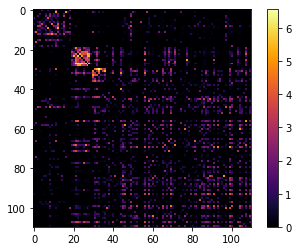

In [132]:
W = A.to_weighted_projection(as_matrix = True)
plt.imshow(utils.sort_matrix(np.log(W+1), ell), cmap = 'inferno')

plt.colorbar()
plt.savefig('fig/partition_matrix.png', dpi = 300)

In [133]:
t = 20

threshed = W.copy()
threshed[threshed < t] = 0

H = nx.from_numpy_array(W, create_using = nx.DiGraph())
G = nx.from_numpy_array(threshed,create_using = nx.DiGraph())

isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)

np.random.seed(1)
layout = nx.fruchterman_reingold_layout(H, weight = 'weight')

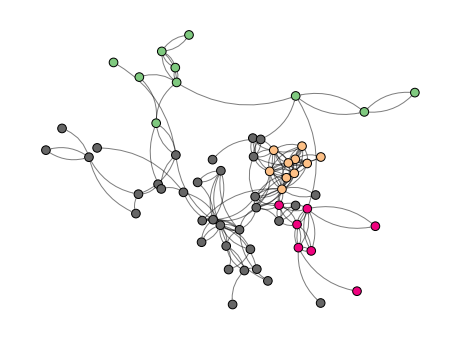

In [134]:
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)

node_size = 75

nx.draw_networkx_edges(G, layout, 
                       edge_color = 'black', 
                       alpha = .5,
                       arrows = True,
                       ax = ax,
                       node_size = node_size, 
                       connectionstyle='arc3, rad=0.25',
                       arrowsize=.2)

nx.draw_networkx_nodes(G, layout,
                       node_color = [ell[i] for i in G.nodes], 
                       node_size = node_size, 
                       ax = ax,
                       edgecolors = 'black', 
                       cmap=plt.get_cmap('Accent'))
ax.axis('off')

plt.savefig('fig/community.png', dpi = 300)

# Batch Comparisons

In [135]:
np.random.seed(1)

Q, ell = get_partition(R, 4, 100)
print(Q, len(np.unique(ell)))

0.5134762047339821 4


In [136]:
R1 = np.ones((3,3))

In [139]:
np.random.seed(1)

Q1, ell1 = get_partition(R1, 4, 100)
print(Q1, len(np.unique(ell1)))

0.5242707816136633 3


In [140]:
observables.MI(ell, ell1, normalize=True)

0.603242773437519